# Proyecto Final (Logística para la Fórmula 1)

**Materia:** Matemáticas Discretas  
**Alumno:** Axel Daniel Malváez Flores  
5to Semestre de la Licenciatura en Ciencia de Datos

## Objetivo del Proyecto

Se tiene como objetivo hacer un plan de viaje para la siguiente temporada de la Fórmula 1. Recorreremos varias ciudades en distintos países y determinaremos cual es la mejor fórma de tener 23 carreras, preferiblemente en países distintos de forma que el recorrido (distancia entre circuitos) sea mínima, esto debido a los altos costos que nos genera transportar las herramientas necesarias para el funcionamiento del equipo en un Grand Prix.   

Añadiremos ciertas métricas que también descartarán circuitos tales como circuitos que ya no tienen contrato o aquellos Grand Prixes que generen un derrame económico alto (usando fuentes externas).

## Recursos

### Data Set
El data set fue obtenido de *Kaggle* en el siguiente link : https://www.kaggle.com/datasets/rohanrao/formula-1-world-championship-1950-2020

### Fuentes de Información

Las siguientes fueron las fuentes de información de las cuales me ayudé para el desarrollo y la implementación de este proyecto. Son links de consulta que nos dirigen a páginas principalmente de documentación para la ayuda de implementación de funciones.

**Graficar la ubicación de los circuitos en un mapa (interactivo)**
* https://geopandas.org/en/stable/gallery/polygon_plotting_with_folium.html
* https://geopandas.org/en/stable/gallery/plotting_with_folium.html
* https://python.plainenglish.io/using-folium-to-map-latitude-and-longitude-491f8dcc81ad
* https://geopandas.org/en/stable/docs/user_guide/mapping.html
* https://geopandas.org/en/stable/gallery/create_geopandas_from_pandas.html
* https://stackoverflow.com/questions/63722124/get-distance-between-two-points-in-geopandas
* https://fontawesome.com/icons?d=gallery

**Dibujar gráficas ponderadas**
* https://networkx.org/documentation/stable/auto_examples/drawing/plot_weighted_graph.html
* https://networkx.org/documentation/stable/auto_examples/drawing/plot_node_colormap.html

**Implementación de algoritmos NetworkX**
* https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.tree.mst.minimum_spanning_tree.html
* https://networkx.org/documentation/stable/reference/algorithms/approximation.html#module-networkx.algorithms.approximation.traveling_salesman

## Exploración Data Set

Dentro de la base de datos de la **Fórmula 1**, utilizaremos el conjunto de datos correspondiente a los **circuitos** de Fórmula 1 que han albergado un Grand Prix. 

In [1]:
# Librerías importantes que utilizaremos en el proyecto
import numpy as np 
import pandas as pd 
import geopandas as gpd 
import matplotlib.pyplot as plt 
import networkx as nx
import seaborn as sns 
import folium
sns.set()
plt.rcParams["figure.figsize"] = (15,15)

GeoDataFrame (necesario para la graficación de los puntos) cargado como *csv*. Nos muestra ciertas características de los circuitos tales como **nombre**, **ubicación** y **coordenadas**.

In [2]:
circuits = pd.read_csv('Formula1/circuits.csv').drop(['url'], axis=1)
circuits.head()

circuitId   circuitRef                            name      location  \
0          1  albert_park  Albert Park Grand Prix Circuit     Melbourne   
1          2       sepang    Sepang International Circuit  Kuala Lumpur   
2          3      bahrain   Bahrain International Circuit        Sakhir   
3          4    catalunya  Circuit de Barcelona-Catalunya      Montmeló   
4          5     istanbul                   Istanbul Park      Istanbul   

     country       lat        lng  alt  
0  Australia -37.84970  144.96800   10  
1   Malaysia   2.76083  101.73800   18  
2    Bahrain  26.03250   50.51060    7  
3      Spain  41.57000    2.26111  109  
4     Turkey  40.95170   29.40500  130

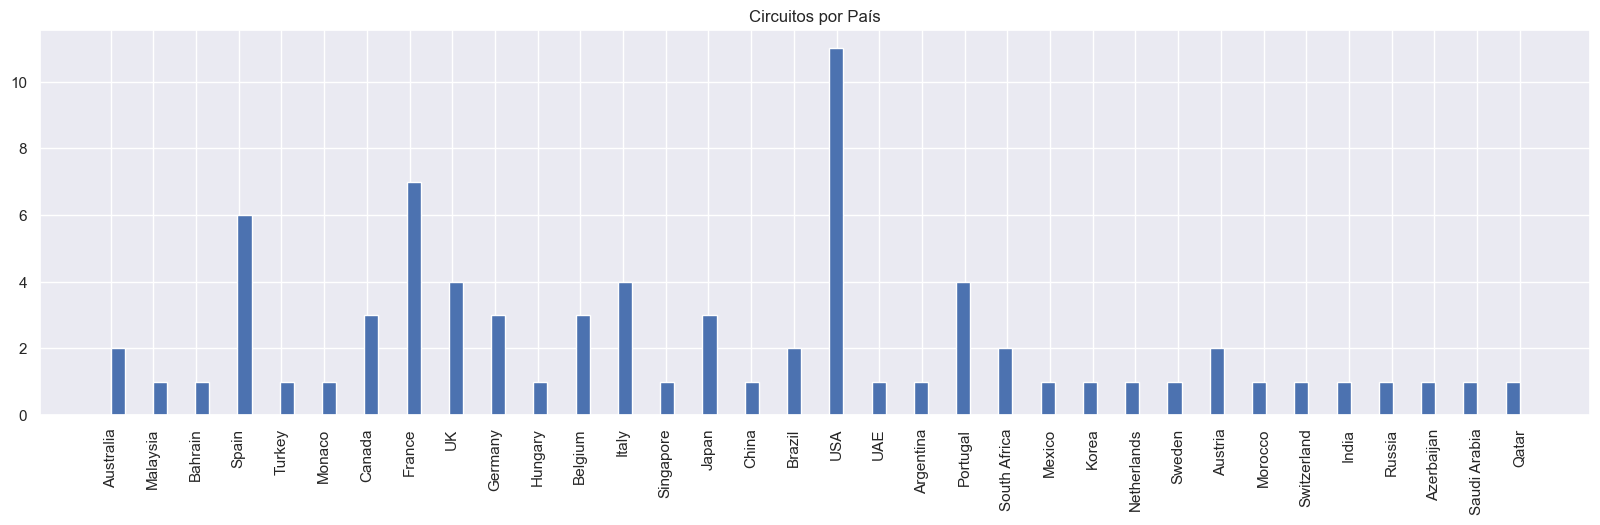

In [3]:
plt.figure(figsize=(20,5))
circuits.country.hist(bins=100)
plt.xticks(rotation=90)
plt.title('Circuitos por País')
plt.show()

## Visualización

Podemos resaltar que para poder de visualizar cada punto en el mapa, debemos de recorrer toda la columna **geometry** de nuestra tabla, lo cual toma tiempo $O(n)$ dependiendo del tamaño de la misma. No obstante la generación del mapa dado que ya es un mapa establecido en los *data sets* de *geopandas*, podremos argumentar que será constante $O(1)$.

Para poder visualizar mejor la información corresondiente al conjunto de datos anteriormente mencionado, dibujamos los circuitos dentro de un mapa mundial. Esta visualización es **útil** para determinar a *grosso modo* que el continente con mayores circuitos que albergan o albergaron un Gran Premio ha sido *Europa*, lo cuál no es novedad debido a que la Fórmula 1 es un deporte con origen en Inglaterra.

In [4]:
circuits = gpd.GeoDataFrame(circuits, geometry=gpd.points_from_xy(circuits.lng, circuits.lat))

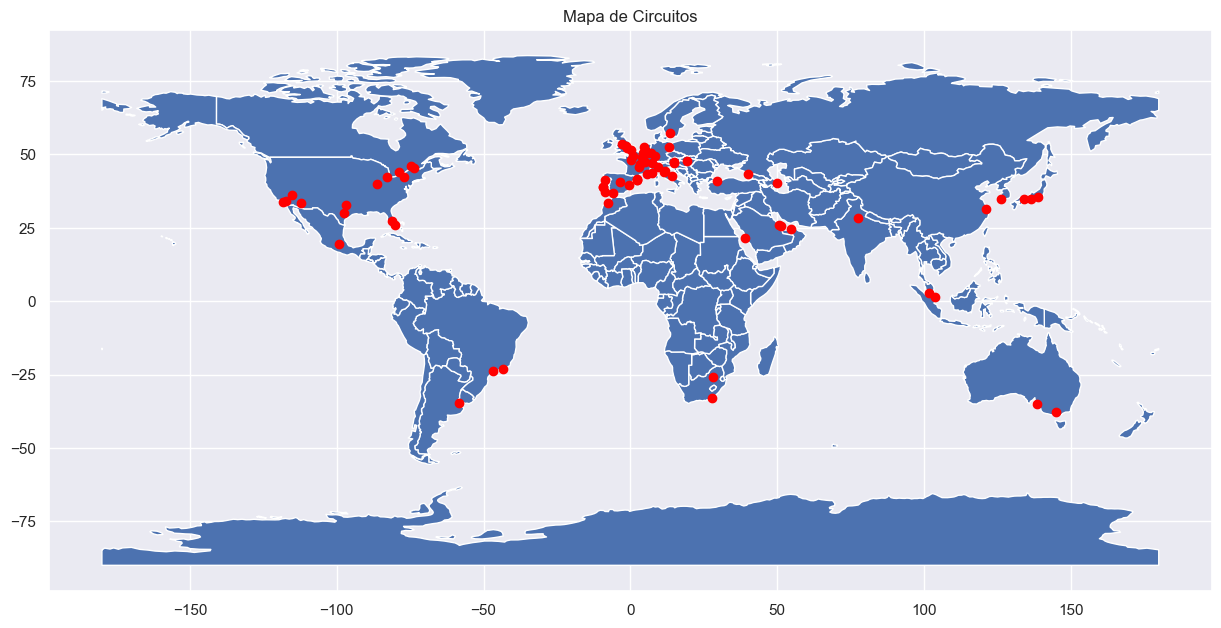

In [5]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

ax = world.plot()
circuits.plot(ax=ax, color='red')
plt.title('Mapa de Circuitos')
plt.show()

Para una mejor visualización con respecto a la ubicación de cada uno de los circuitos de la Fórmula 1, utilizamos un mapa interactivo de la paquetería **Folium** y dentro del cuál asignamos un pin a la ubicación real de cada circuito.

In [6]:
m = folium.Map()
for _, r in circuits.iterrows():
    lat = r['geometry'].y
    lon = r['geometry'].x
    folium.Marker(icon=folium.Icon(color='blue', icon='flag-checkered', prefix='fa'),location=[lat, lon],
                  popup='Circuit Name: {} <br> Country: {}'.format(r['name'], r['country'])).add_to(m)

m

## Gráfica NetworkX

El siguiente paso será trasladar nuestros puntos mostrados en los mapas anteriores a una gráfica de NetworkX a la que podamos asignarle pesos a las aristas (distancia entre circuito y circuito) y así aplicar algoritmos correspondientes a gráficas ponderadas.

Distancias entre dos autódromos (cambiamos la métrica para que el cálculo de la misma nos la regrese en metros)

In [7]:
# Cambio de crs
circuits = circuits.set_crs('epsg:4326')
circuits = circuits.to_crs(epsg=32631)

In [8]:
# Obtenemos dos circuitos uno de Australia y otro de España
circuit_1 = circuits.loc[0]
circuit_2 = circuits.loc[3]

In [25]:
print(f'La distancia entre el circuito {circuit_1[2]} ubicado en {circuit_1[4]} y el circuito {circuit_2[2]} ubicado en {circuit_2[4]} es {(circuit_1[8].distance(circuit_2[8]) / 1000)} km')

La distancia entre el circuito Albert Park Grand Prix Circuit ubicado en Australia y el circuito Circuit de Barcelona-Catalunya ubicado en Spain es 19956.335372858866 km


Lo siguiente que haremos para poder crear nuestra gráfica será construir **diccionarios** que nos permitan interpretar nuestras gráficas y así hacer una visualización más sencilla de la misma. Elegimos esta estructura de datos debido a la complejidad en tiempo de obtener un elemento dada una llave, esto porque necesitaremos conocer en bastantes ocaciones el nombre del autódromo asociado a un número entre el $0$ y el $75$. Para lo cual hacerlo en $O(1)$ nos hace más rápida aún la búsqueda.

In [10]:
dict_circuits = {i:circuits['name'][i] for i in range(len(circuits))}

In [11]:
inverse_dict_circuits = {circuits['name'][i]:i for i in range(len(circuits))}

Para el cálculo de las distancias entre cada punto corresponde a crear una gráfica completa donde el peso de cada arista sea la distancia entre los circuitos que conecta. Dado que sabemos que una gráfica de $n$ vértices tiene a lo más 

$${n\choose{2}}$$   

aristas entonces la complejidad de crear una lista de tuplas que contenga las combinaciones de los $76$ circuitos en grupos de $2$ será de $O(2 * {n\choose 2}) = O(n^2 - n) = O(n^2)$.

In [12]:
from itertools import combinations

num_circuits = [i for i in range(76)]
comb = list(combinations(num_circuits, 2))

Después para cada combinación creamos nuestra arista y es aquí cuando aprovechamos la complejidad de obtención de elementos en nuestro diccionario debido a que para saber qué punto de qué autódromo corresponde a un cierto número en una tupla $i$ de nuestras combinaciones, necesitamos acceder a buscarlo con la llave como número.

In [13]:
G = nx.Graph()

for i in comb:
    x,y = i
    x_node = circuits[circuits['name'] == dict_circuits[x]].values[0][8]
    y_node = circuits[circuits['name'] == dict_circuits[y]].values[0][8]
    dist = x_node.distance(y_node)
    G.add_edge(x,y, weight=dist)

La creación de nuestra gráfica ponderada es un poco lenta debido a que aunado a dibuar cada una de las aristas de cada punto, también asigna ciertos atributos como colores, etiquetas y distancia en las aristas.

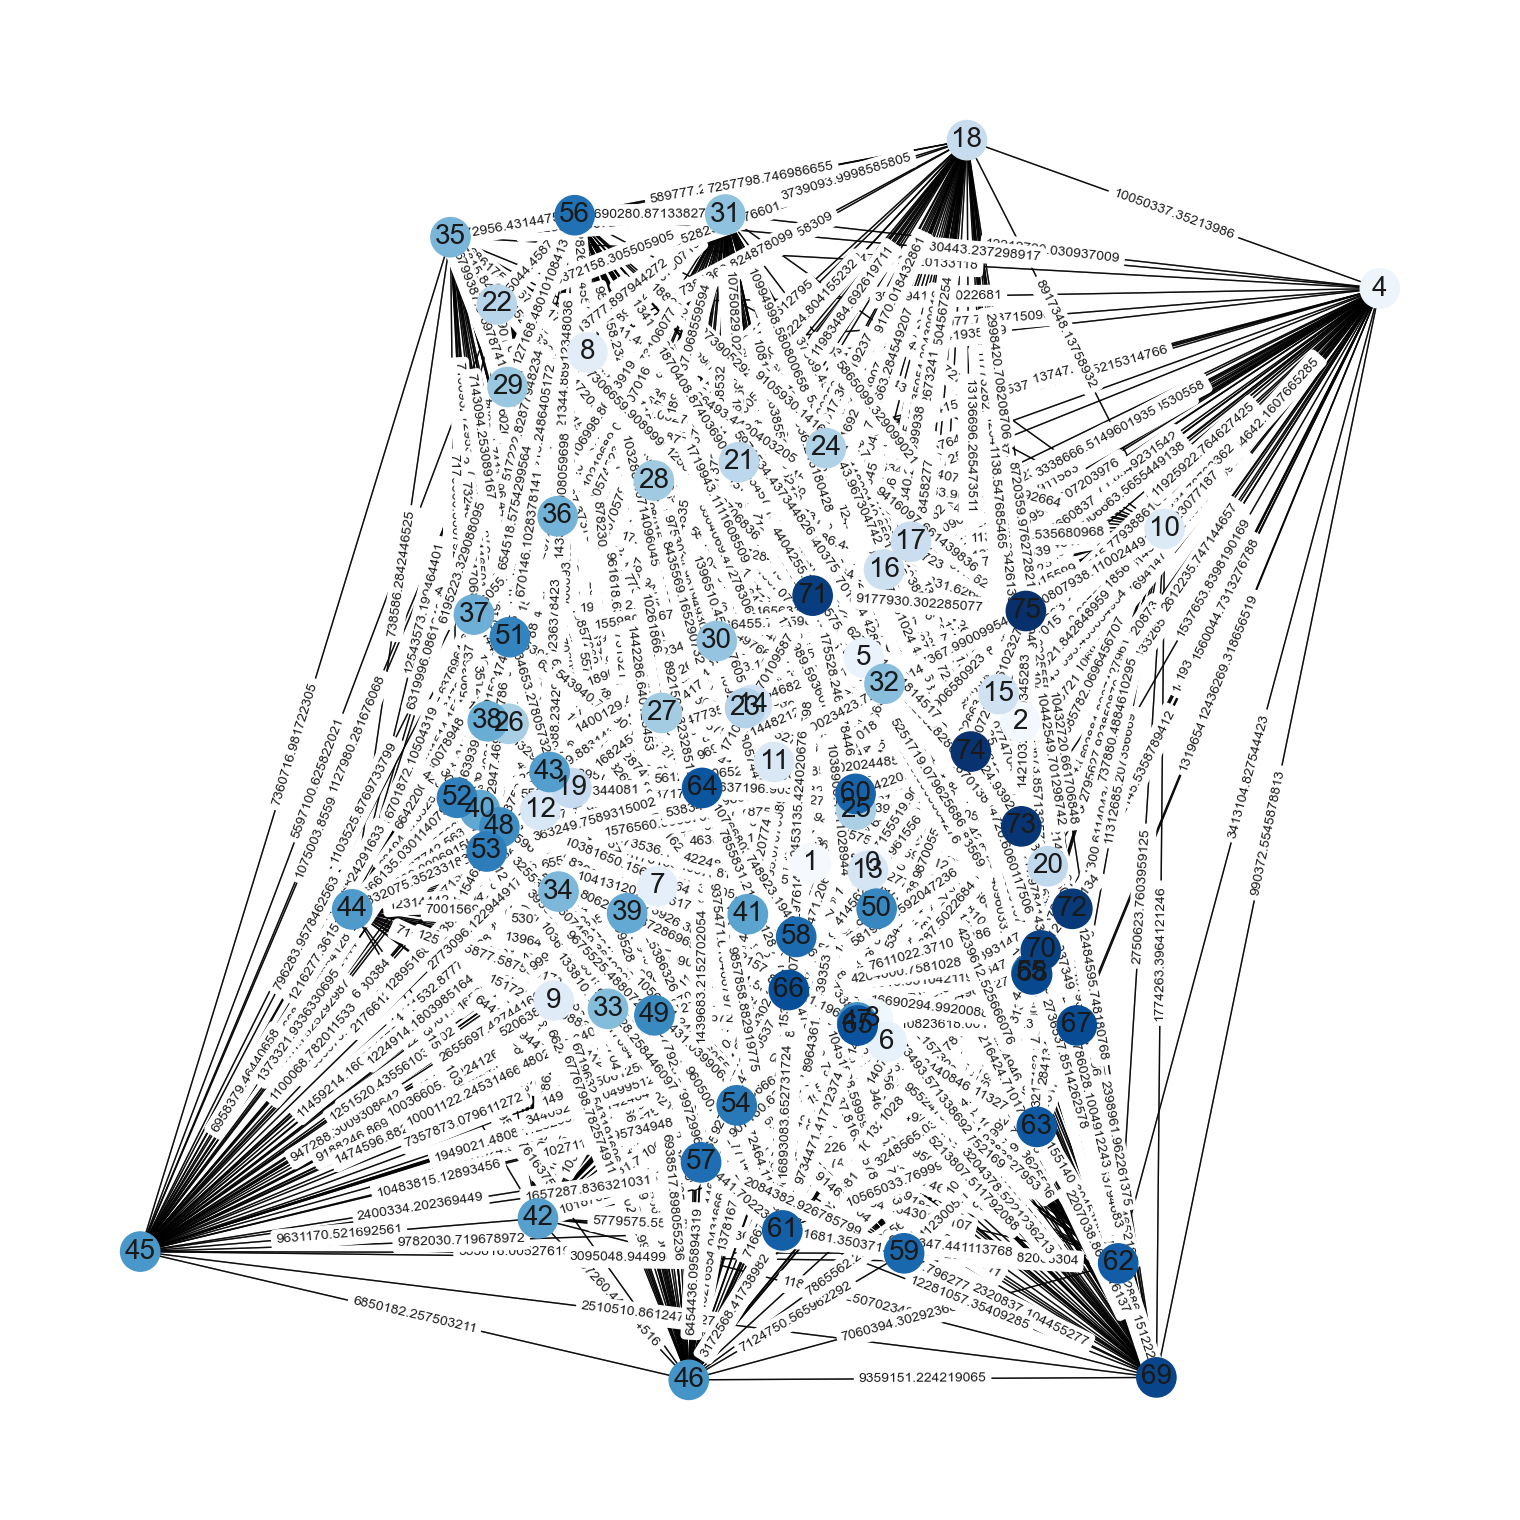

In [14]:
pos = nx.kamada_kawai_layout(G)
nx.draw(G, pos, node_color=range(76), node_size=800, cmap=plt.cm.Blues)
#nx.draw_networkx_edges(G, pos, width=6)
nx.draw_networkx_edges(
    G, pos, width=1, alpha=0.5, edge_color="black", style="solid"
)
# node labels
nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")

# edge weight labels
edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels)

plt.show()

## Algoritmos en gráficas

Aplicaremos los siguientes algoritmos a nuestra gráfica correspondiente a los circuitos:
* Deepth First Search (DFS)
* Breadth First Search (BFS)
* Prim
* Kruskal
* Boruvka
* Traveler Salesman Problem (TSP) algoritmo NP-Completo

### DFS

El siguiente es el árbol resultante del recorrido **DFS** de nuestra gráfica de Circuitos. Comenzamos en el circuito 0 correspondiente al 'Albert Park Grand Prix Circuit'.   

Notemos que el recorrido de DFS al ser de profundidad y hacer uso de un stack, el árbol generado con DFS recorre a la gráfica en el orden del $0-75$ esto pues como $G$ es completa, el resultado parece semejante a recorrer una lista de los números ordenados.   

Tenemos que la complejidad en tiempo del puro algoritmo **DFS** es de $O(|V| + |E|)$ con $|V| = $ **número de vértices** y $|E| = $ **número de aristas**. Esto sin el incremento de la complejidad al crear la gráfica (intuitivamente resulta ser $O(|V|)$ pues se recorre la lista que nos regresa DFS, no obstante no conocemos la complejidad de añadir un nodo y una arista, probablemente es $O(1)$).

Pseudocódigo:

```
func DFS(G, u, visitados):
    marcamos u como visitado en visitados
        para cada vertice v adyacente a u en G: 
            si v no ha sido visitado en visitados:
               marcamos como visitado v en visitados
               llamamos recursivamente DFS(G, v, visitados)  
```

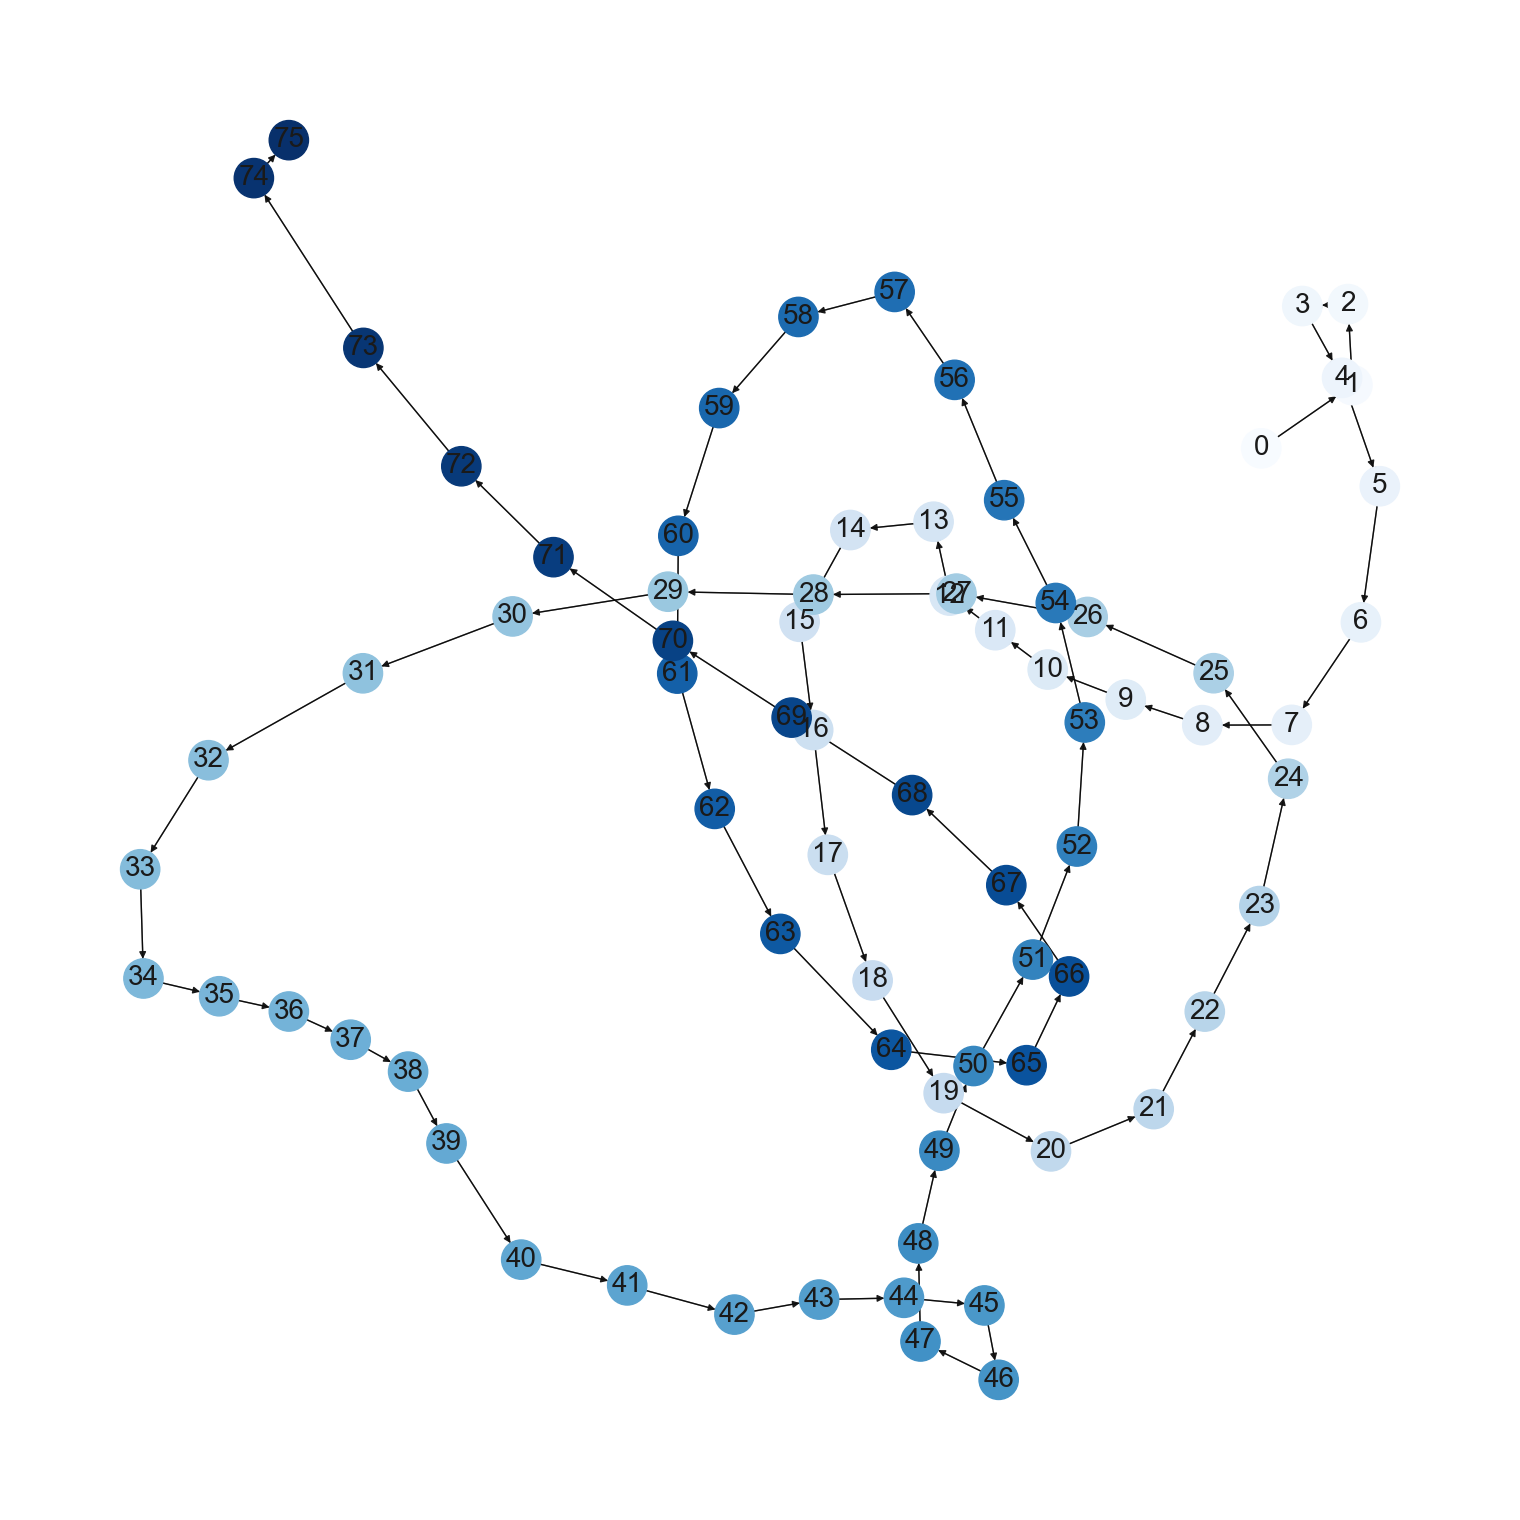

In [15]:
dfs_graph = nx.dfs_tree(G, 0)
pos = nx.spring_layout(dfs_graph, seed=76)
nx.draw(dfs_graph, pos, node_color=range(76), node_size=800, cmap=plt.cm.Blues)
nx.draw_networkx_edges(
    dfs_graph, pos, width=1, alpha=0.5, edge_color="black", style="solid"
)
# node labels
nx.draw_networkx_labels(dfs_graph, pos, font_size=20, font_family="sans-serif")

# edge weight labels
edge_labels = nx.get_edge_attributes(dfs_graph, "weight")
nx.draw_networkx_edge_labels(dfs_graph, pos, edge_labels)

plt.show()

### BFS

El siguiente es el árbol resultante del recorrido **BFS** de nuestra gráfica de Circuitos. Comenzamos en el circuito $0$ correspondiente al 'Albert Park Grand Prix Circuit'.   

Notemos que el recorrido de BFS al ser realizado por anchura y hacer uso de una cola, el árbol generado con BFS recorre a todos primero a todos los vecinos del vértice $0$, no obstante dado que la gráfica es completa, es por esto que se ve como un círculo donde el centro es el $0$ y sus demás hijos son los vértices restantes.

Tenemos que la complejidad en tiempo del puro algoritmo **DFS** es de $O(|V| + |E|)$ suponiendo que vemos a nuestra gráfica como una lista de adyacencias siendo $|V| = $ **número de vértices** y $|E| = $ **número de aristas**. Esto sin el incremento de la complejidad al crear la gráfica (intuitivamente resulta ser $O(|V|)$ pues se recorre la lista que nos regresa DFS, no obstante no conocemos la complejidad de añadir un nodo y una arista, probablemente es $O(1)$).   

Pseudocódigo:

```
func BFS(G,v):
    creamos una cola Q
    creamos una lista visitados
    añadimos v a la cola Q
    marcamos v como visitado en visitados
    mientras Q no este vacío:
        sacamos un elemento v de la cola Q
        para cada vertice w adyacente a v en la gráfica: 
            si w no ha sido visitado:
               marcamos como visitado w en visitados
                insertamos w dentro de la cola Q
```

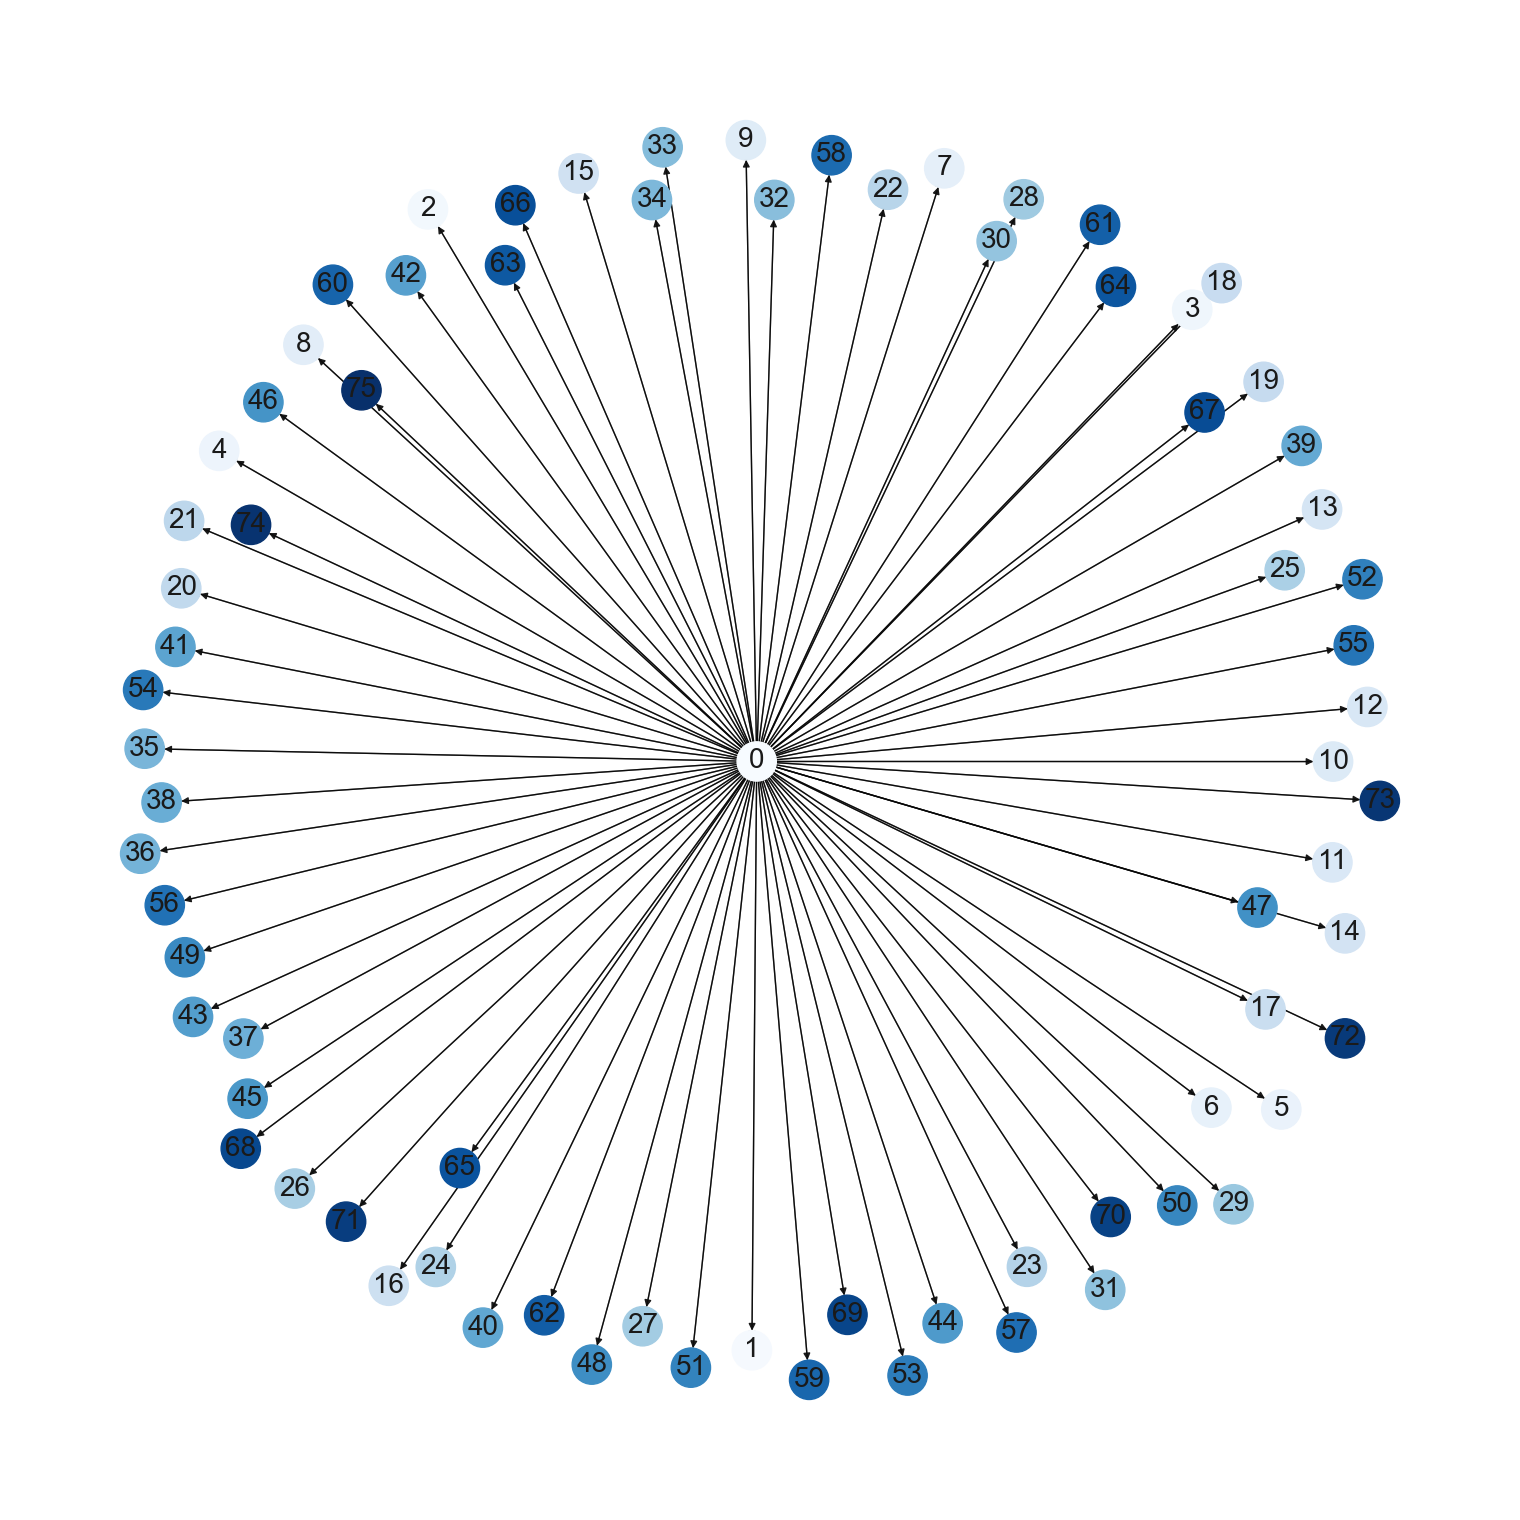

In [16]:
bfs_graph = nx.bfs_tree(G, 0)
pos = nx.spring_layout(bfs_graph, seed=76)
nx.draw(bfs_graph, pos, node_color=range(76), node_size=800, cmap=plt.cm.Blues)
nx.draw_networkx_edges(
    bfs_graph, pos, width=1, alpha=0.5, edge_color="black", style="solid"
)
# node labels
nx.draw_networkx_labels(bfs_graph, pos, font_size=20, font_family="sans-serif")

# edge weight labels
edge_labels = nx.get_edge_attributes(bfs_graph, "weight")
nx.draw_networkx_edge_labels(bfs_graph, pos, edge_labels)

plt.show()

### Algoritmo de Prim

Dado que nuestro objetivo es trazar rutas y conocer las distancias entre los circuitos, un algoritmo que nos será de utilidad será el algoritmo de prim cuyo objetivo es encontrar un árbol generador mínimo en una gráfica conexa, no dirigida y cuyas aristas están ponderadas.   

Este es un algoritmo que encuentra un subconjunto de aristas que forman un árbol con todos los vértices, donde el peso total de todas las aristas en el árbol es el mínimo posible.   

La complejidad de este algoritmo depende de la estructura en la que $G$ esté implementada, de estar en una matriz de adyacencias su complejidad será de $O(|V|^2)$, no obstante si tenemos que $G$ se almacena en un Fibonacci Heap, entonces su complejidad se reduce a $O(|E| + |V|\log |V|)$

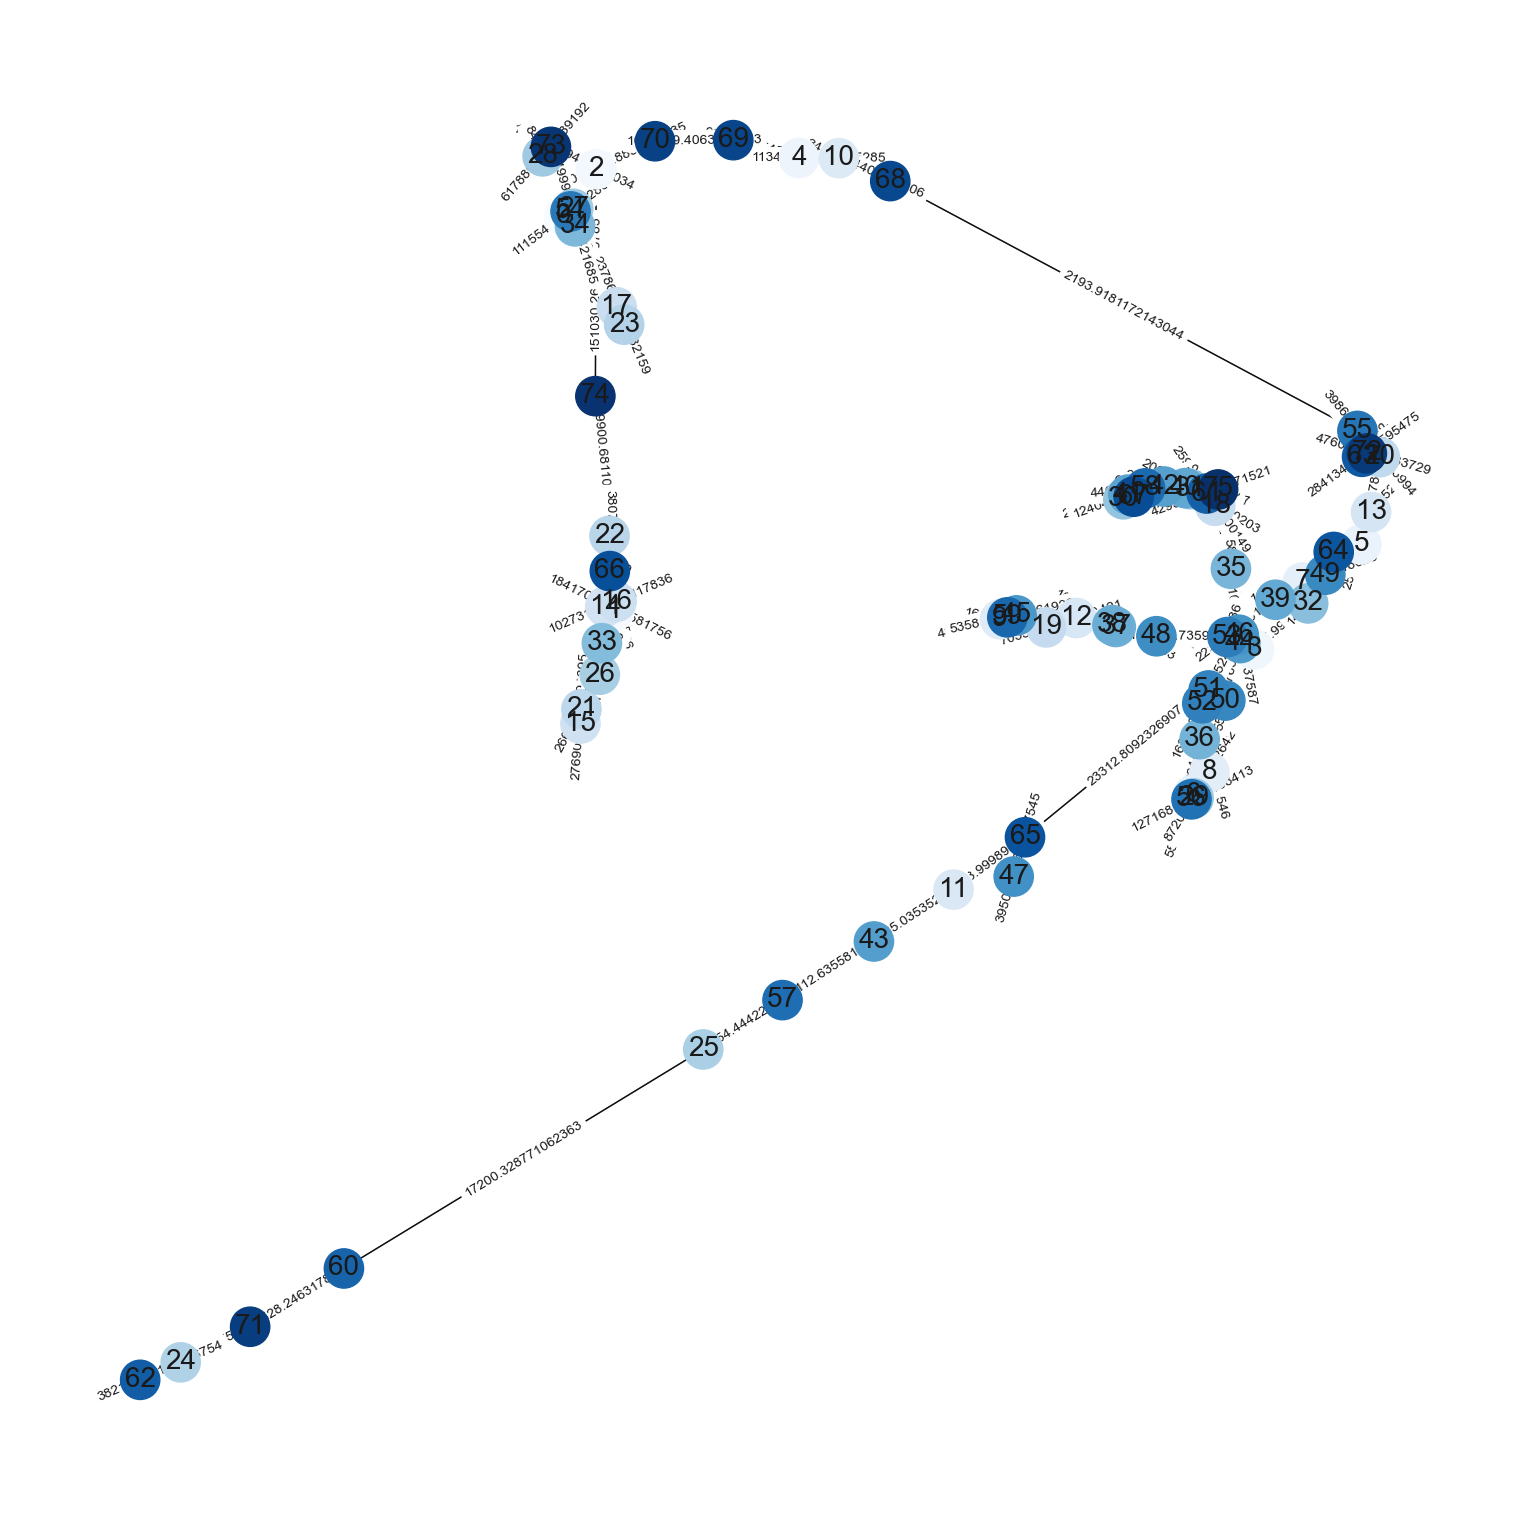

In [17]:
minimum_prim_tree = nx.minimum_spanning_tree(G, algorithm='prim', weight='weight')
pos = nx.spring_layout(minimum_prim_tree, seed=76)
nx.draw(minimum_prim_tree, pos, node_color=range(76), node_size=800, cmap=plt.cm.Blues)
nx.draw_networkx_edges(
    minimum_prim_tree, pos, width=1, alpha=0.5, edge_color="black", style="solid"
)
# node labels
nx.draw_networkx_labels(minimum_prim_tree, pos, font_size=20, font_family="sans-serif")

# edge weight labels
edge_labels = nx.get_edge_attributes(minimum_prim_tree, "weight")
nx.draw_networkx_edge_labels(minimum_prim_tree, pos, edge_labels)

plt.show()

### Algoritmo Kruskal

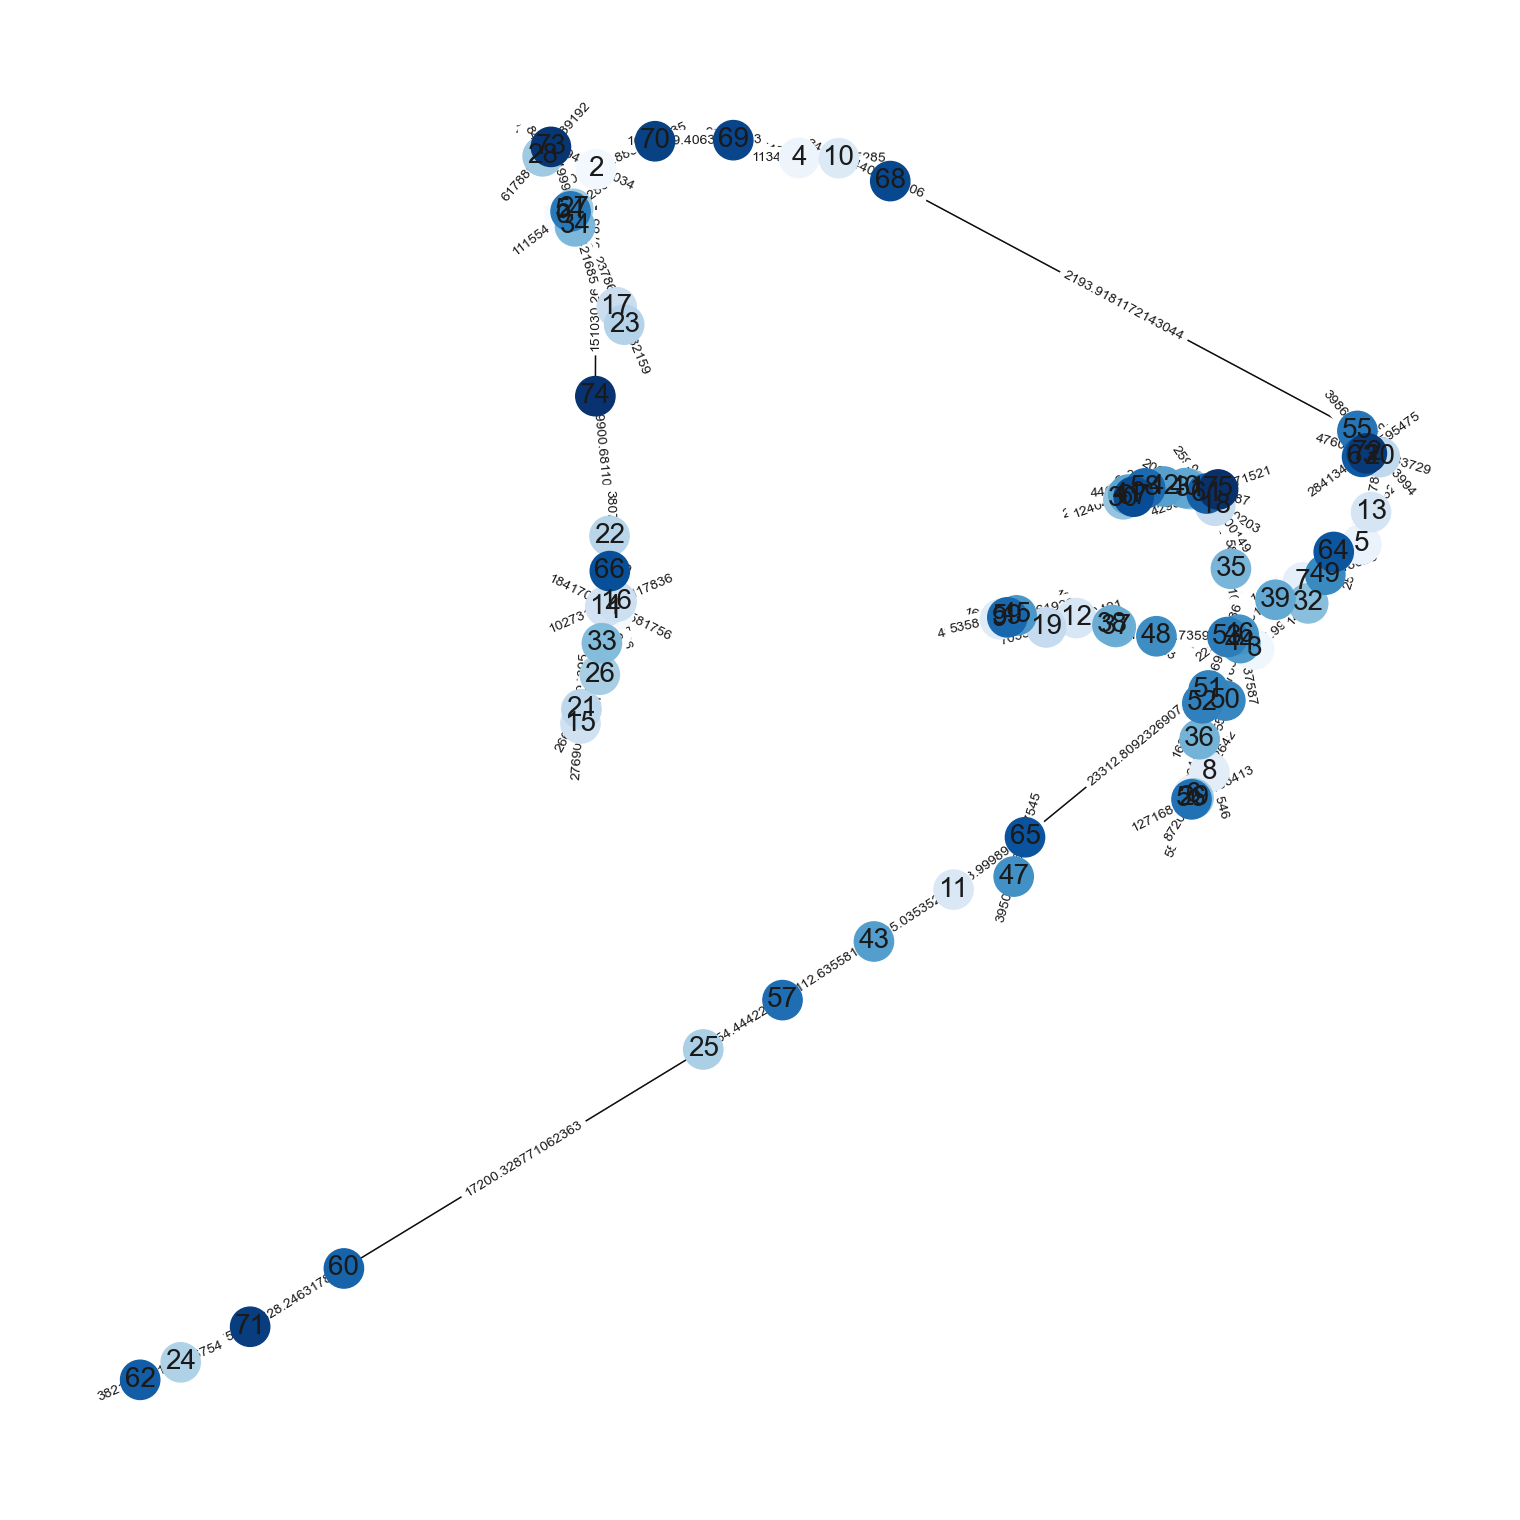

In [18]:
minimum_prim_tree = nx.minimum_spanning_tree(G, algorithm='kruskal', weight='weight')
pos = nx.spring_layout(minimum_prim_tree, seed=76)
nx.draw(minimum_prim_tree, pos, node_color=range(76), node_size=800, cmap=plt.cm.Blues)
nx.draw_networkx_edges(
    minimum_prim_tree, pos, width=1, alpha=0.5, edge_color="black", style="solid"
)
# node labels
nx.draw_networkx_labels(minimum_prim_tree, pos, font_size=20, font_family="sans-serif")

# edge weight labels
edge_labels = nx.get_edge_attributes(minimum_prim_tree, "weight")
nx.draw_networkx_edge_labels(minimum_prim_tree, pos, edge_labels)

plt.show()

### Algoritmo Boruvka

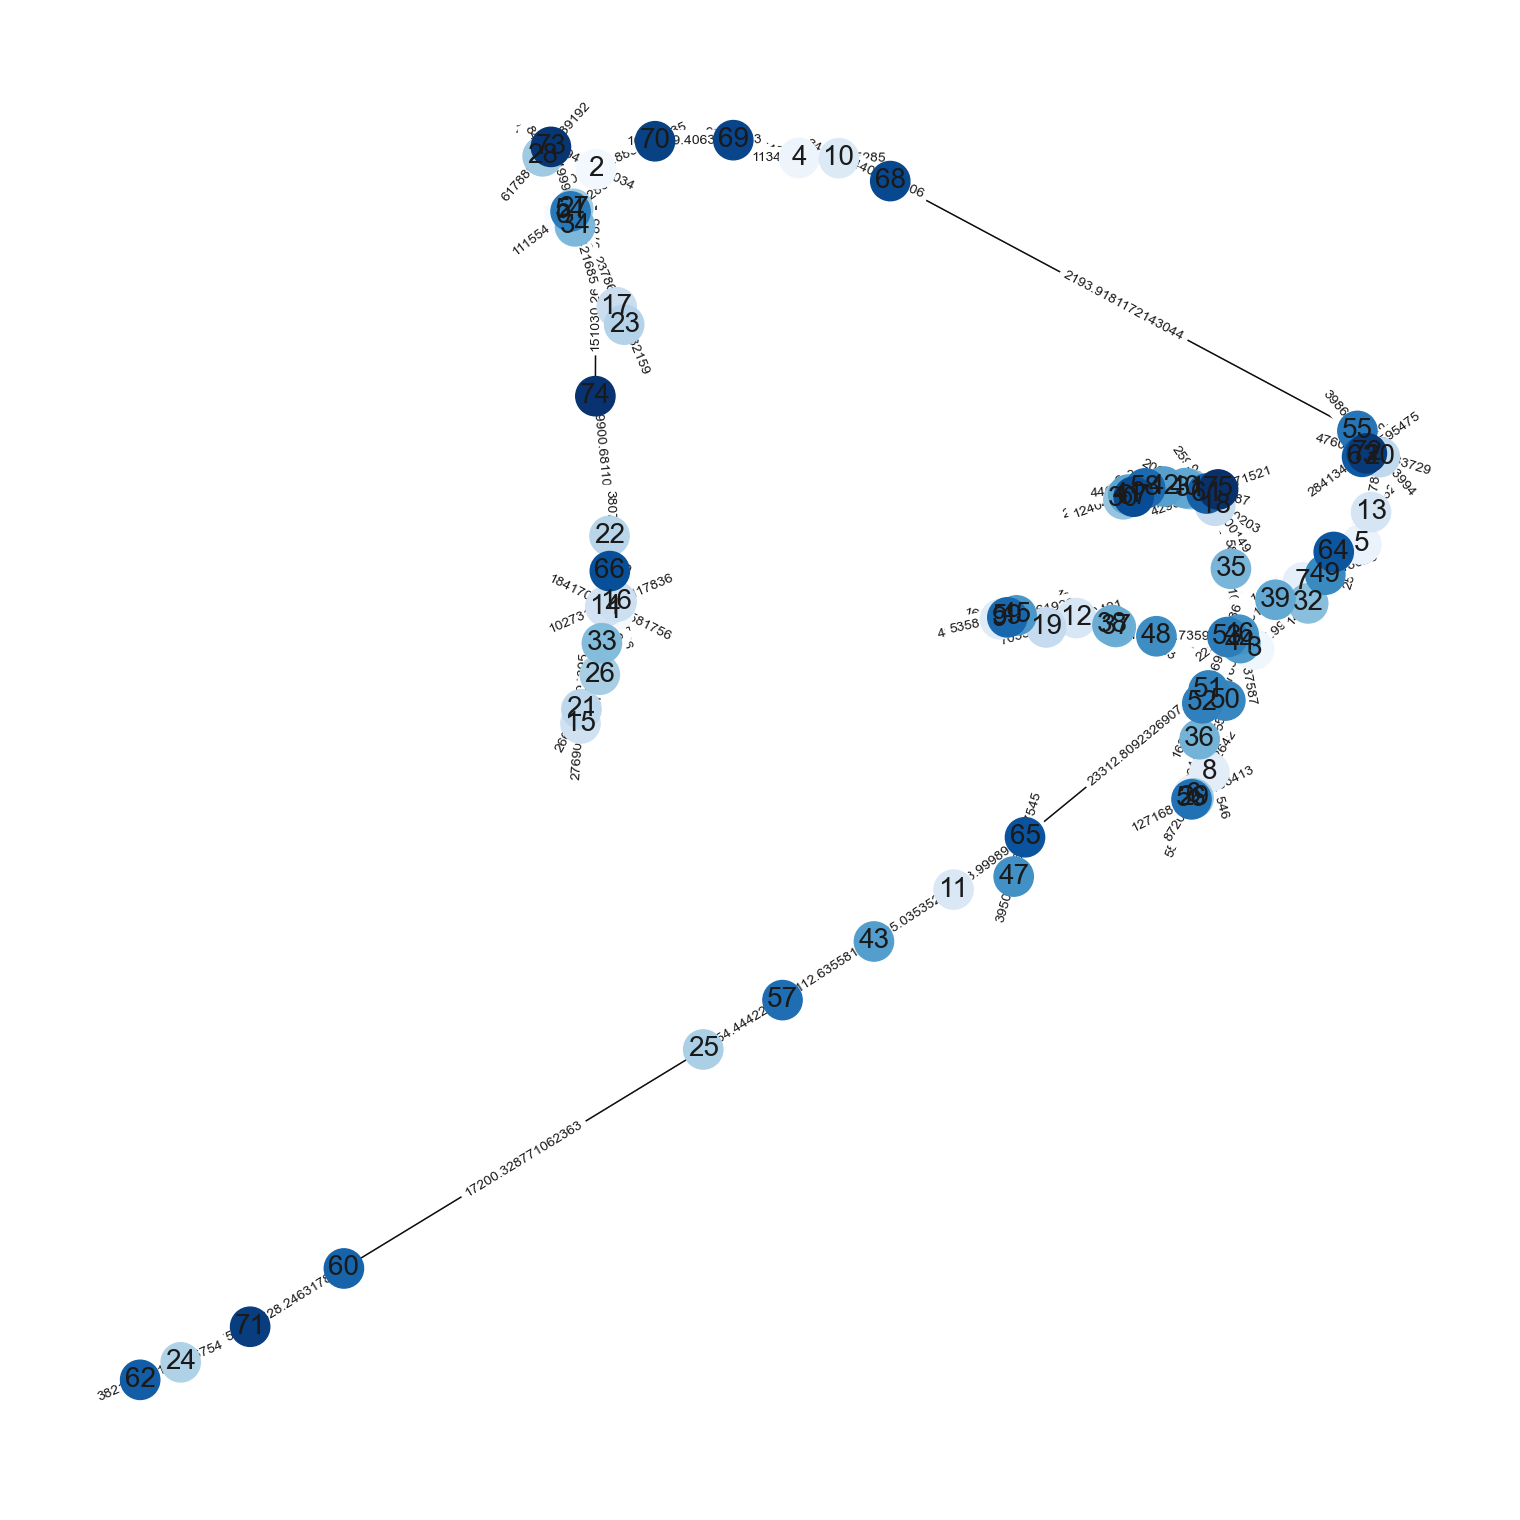

In [19]:
minimum_prim_tree = nx.minimum_spanning_tree(G, algorithm='boruvka', weight='weight')
pos = nx.spring_layout(minimum_prim_tree, seed=76)
nx.draw(minimum_prim_tree, pos, node_color=range(76), node_size=800, cmap=plt.cm.Blues)
nx.draw_networkx_edges(
    minimum_prim_tree, pos, width=1, alpha=0.5, edge_color="black", style="solid"
)
# node labels
nx.draw_networkx_labels(minimum_prim_tree, pos, font_size=20, font_family="sans-serif")

# edge weight labels
edge_labels = nx.get_edge_attributes(minimum_prim_tree, "weight")
nx.draw_networkx_edge_labels(minimum_prim_tree, pos, edge_labels)

plt.show()

### TSP

In [20]:
tsp = nx.approximation.traveling_salesman_problem(G, cycle=False)
tsp

[66,
 22,
 74,
 73,
 28,
 34,
 17,
 23,
 27,
 0,
 54,
 2,
 70,
 69,
 4,
 10,
 68,
 55,
 20,
 63,
 72,
 13,
 64,
 39,
 7,
 49,
 62,
 24,
 71,
 60,
 25,
 57,
 43,
 11,
 65,
 47,
 3,
 32,
 5,
 53,
 48,
 38,
 37,
 45,
 59,
 9,
 19,
 12,
 51,
 52,
 36,
 8,
 29,
 56,
 6,
 50,
 46,
 44,
 35,
 18,
 75,
 61,
 40,
 30,
 67,
 31,
 42,
 58,
 41,
 15,
 21,
 26,
 33,
 16,
 14,
 1]

In [21]:
tsp = nx.approximation.greedy_tsp(G, source=0)
tsp

[0,
 27,
 54,
 28,
 73,
 2,
 74,
 22,
 70,
 69,
 4,
 10,
 68,
 55,
 20,
 72,
 13,
 64,
 39,
 7,
 49,
 52,
 51,
 53,
 48,
 38,
 12,
 19,
 9,
 37,
 36,
 8,
 29,
 56,
 59,
 45,
 5,
 32,
 3,
 65,
 47,
 11,
 43,
 57,
 25,
 60,
 71,
 24,
 62,
 63,
 6,
 50,
 46,
 44,
 35,
 18,
 40,
 67,
 31,
 42,
 58,
 41,
 30,
 61,
 75,
 34,
 17,
 23,
 66,
 16,
 33,
 26,
 21,
 15,
 14,
 1,
 0]